In [1]:
import os
import glob
import subprocess
import numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.visualization import astropy_mpl_style
from photutils import CircularAperture
from photutils import aperture_photometry
from astropy.visualization import simple_norm

In [2]:
files = glob.glob('data/*.fits')

Let's see what information we can find about the images from their FITS headers

In [3]:
hdu = fits.open(files[0])

In [4]:
w = WCS(hdu[0].header)

 [astropy.io.fits.verify]
Changed DATE-OBS from '17/12/2000' to '2000-12-17''. [astropy.wcs.wcs]


In [5]:
def get_img(self): #smart way #returns 2D array from fits file data
    hdul = fits.open(self)
    image = np.asarray(hdul[0].data)
    #image = np.array(image).astype(np.float16)
    #reads data section of fits into an array as float
    hdul.close() #closing the file. GOTTA save RAM!
    return image

In [6]:
def imgshow(image): #display the image
    plt.figure(figsize=(8,8)) #size
    plt.style.use(astropy_mpl_style) #styling and gimmicks of astropy
    plt.imshow(image,vmin=np.median(image)-1*np.std(image),
               vmax=np.median(image)+10*np.std(image),cmap='gray')
    #use this for contrast stretching

    plt.colorbar() #a bar showing the scale of the image
#     plt.show()
#     plt.close()

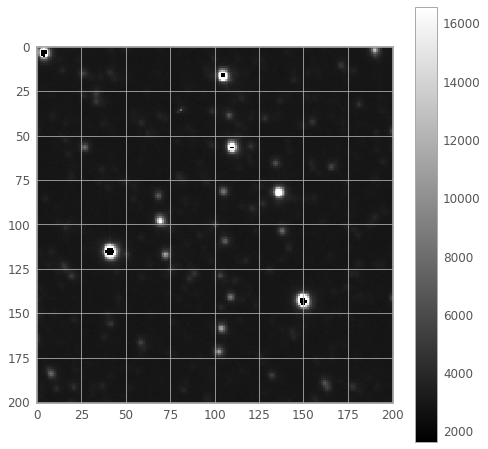

In [7]:
imgshow(hdu[0].data)

In [8]:
from photutils import CircularAperture
positions = [(101., 101.)]
aperture = CircularAperture(positions, r=5.)

In [9]:
image = hdu[0].data
phot_table = aperture_photometry(image, aperture)
# phot_table = aperture_photometry(data, aperture, method='subpixel',subpixels=5)
phot_table['aperture_sum'].info.format = '%.8g'

In [10]:
print(phot_table)  

 id xcenter ycenter aperture_sum
      pix     pix               
--- ------- ------- ------------
  1   101.0   101.0    261516.38


In [11]:
radii = [3., 4., 5.]
apertures = [CircularAperture(positions, r=r) for r in radii]
phot_table = aperture_photometry(image, apertures)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1 aperture_sum_2
      pix     pix                                               
--- ------- ------- -------------- -------------- --------------
  1     101     101       101091.4      172235.41      261516.38


In [12]:
from photutils import CircularAnnulus
annulus_aperture = CircularAnnulus(positions, r_in=10., r_out=15.)

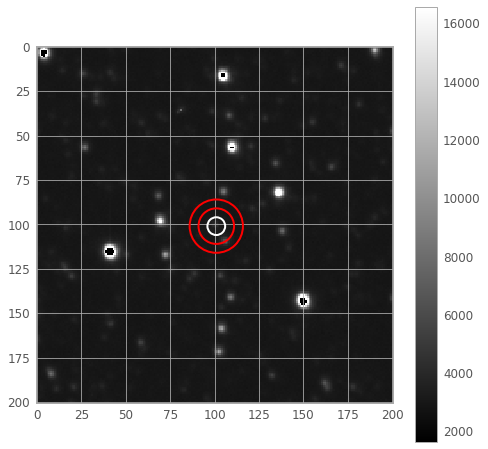

In [164]:
norm = simple_norm(image, 'sqrt', percent = 99)
# plt.imshow(image, norm=norm,interpolation='nearest',cmp='grey')
imgshow(image)
aperture.plot(color='white',lw=2)
annulus_aperture.plot(color='red',lw=2)

In [166]:
apers = [aperture, annulus_aperture]
phot_table = aperture_photometry(image, apers)
for col in phot_table.colnames:
    phot_table[col].info.format = '%.8g'  # for consistent table output
print(phot_table)

 id xcenter ycenter aperture_sum_0 aperture_sum_1
      pix     pix                                
--- ------- ------- -------------- --------------
  1     101     101      261516.38      1209578.8


In [167]:
bkg_mean = phot_table['aperture_sum_1'] / annulus_aperture.area

In [168]:
bkg_sum = bkg_mean * aperture.area
final_sum = phot_table['aperture_sum_0'] - bkg_sum
phot_table['residual_aperture_sum'] = final_sum
phot_table['residual_aperture_sum'].info.format = '%.8g'  # for consistent table output
print(phot_table['residual_aperture_sum'])  

residual_aperture_sum
---------------------
            19600.618


In [144]:
from photutils.datasets import make_100gaussians_image
from photutils import CircularAperture, CircularAnnulus
data = make_100gaussians_image()
positions = [(145.1, 168.3), (84.5, 224.1), (48.3, 200.3)]
aperture = CircularAperture(positions, r=5)
annulus_aperture = CircularAnnulus(positions, r_in=10, r_out=15)


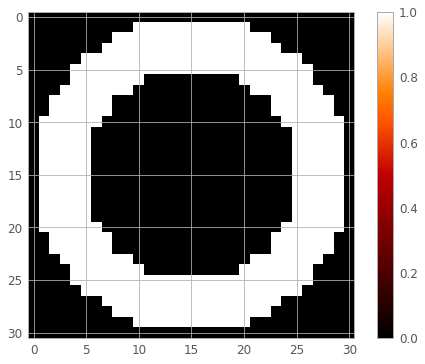

In [104]:
annulus_masks = annulus_aperture.to_mask(method='center')
plt.imshow(annulus_masks[0], interpolation='nearest')
plt.colorbar()

In [50]:
annulus_data = annulus_masks[0].multiply(data)


In [51]:
mask = annulus_masks[0].data
annulus_data_1d = annulus_data[mask > 0]
annulus_data_1d.shape

(394,)